In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import math
from collections import OrderedDict
import residuals as r

%matplotlib inline
import matplotlib.gridspec as gridspec
plt.rcParams['font.family']='serif'

micro = 10**(6)

from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [35]:
def weighted_stddev(values, errors):
    '''
    Return the weighted average and standard deviation.

    '''
    weights = 1. / ((errors)**2)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (math.sqrt(variance))

def magnitude(x):
    '''
    Return the magnitude of a variable
    '''
    var = float(x)
    return int(math.floor(math.log10(var)))

In [ ]:
def make_arrays(psrname, MJDint):
    condition_lower=MJDint
    condition_upper=MJDint+0.99
    
    jitter_ratios = OrderedDict()
    corr_coefs = OrderedDict()
    file_names = []
    for elem in ['320','160','80', '40', '20', 'NT']:
        #Define sigma_all (or std_all) as entire observation period
        x=r.read_residuals(filename="/nimrod1/eschwab/residuals/%s_resid_%s_%sF8.tmp" %(psrname, MJDint, elem))
        
        condition = (x.bary_TOA > condition_lower) & (x.bary_TOA < condition_upper) & (x.bary_freq > 1221.0) & (x.bary_freq < 2000.0)
        Resid_all = x.prefit_sec[condition]
        Errors_all = x.uncertainty[condition]
        std_all = weighted_stddev(Resid_all, Errors_all)

        ##============

        #Define sigma_dump (or std_all) as individual dumps within observation period

        #This isolates the numbers for the different dump times
        rounded = np.round(np.array([x.bary_TOA[condition] - 0.00005]), 4)
        dumptimes=[]
        for i in rounded.tolist()[0]: 
            if i not in dumptimes:
                dumptimes.append(i)

        #This calculates a list of sigma_dump values and averages those
        str_dump_devs=[]
        for i in dumptimes:
            timeindex = (rounded == i)[0]
            Resid = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            single_std_dump = weighted_stddev(Resid, Errors)
            str_dump_devs.append(single_std_dump)

        #to convert str_dump_devs out of scientific notation
        dump_devs=[]
        for i in str_dump_devs:
            dump_devs.append('{0:.20f}'.format(i))

        #prints the magnitude of each sigma_dump in a list and finds average magnitude
        magarray=[]
        for i in dump_devs:
            magarray.append(magnitude(i))
        averagemag = round(np.mean(magarray))

        arg=averagemag+1.5
        makemask = np.ma.masked_where(np.array(magarray) > arg, np.array(magarray))

        std_dump=np.mean(str_dump_devs)
        masked_std_dump = np.mean(np.ma.masked_where(np.ma.getmask(makemask), str_dump_devs))

        #Setup jitter ratio
        ratio = std_all / std_dump
        masked_ratio = float(std_all / masked_std_dump)
        jitter_ratios[elem] = masked_ratio

        ##============

        #Print out the correlation coefficient also, to allow for easy reference

        #Creating the matrix of the data and transposing it to correct format
        data = []
        data_errors = []
        for i in dumptimes[1:]: #the first set of resids needs to be skipped in J1713, but not sure for all of them?
            timeindex = (rounded == i)[0]
            Resids = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            data.append(Resids)
            data_errors.append(Errors)

        data = map(list, zip(*data)) #transposing the matrix, supposedly unnecessary if rowvar=0 in corr but gives errors

        #Using the Weighted Correlation Coefficient from wikipedia
        #https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Weighted_correlation_coefficient
        # I added weights by creating a weighted value to multiply each data element by
        #The weighted values are normalized by dividing each value by the sum of all weights

        data_weights = 1. / (np.array(data_errors)**2)
        data_weights = map(list, zip(*(data_weights.tolist())))

        #data_weights is a matrix of all the weights

        norm_weights = []
        for i in data_weights:
            norm_weights.append([j/sum(i) for j in i])

        weighted_data = []
        for i,j in zip(data, norm_weights):
            weighted_data.append([a*b for a,b in zip(i,j)])

        #Correlating! 
        corr = np.corrcoef(data)
        weighted_corr = np.corrcoef(weighted_data)

        unique_corrs = []
        #Averaging the correlation
        for i in range(len(corr)):
            unique_corrs.append(corr[i][i+1:]) #because numpy array, double index necessay
        unique_corrs  = [val for sublist in unique_corrs for val in sublist]
        final_coefficient = np.average(unique_corrs)

        unique_weighted_corrs = []
        #Averaging the correlation
        for i in range(len(weighted_corr)):
            unique_weighted_corrs.append(weighted_corr[i][i+1:]) #because numpy array, double index necessay
        unique_weighted_corrs  = [val for sublist in unique_weighted_corrs for val in sublist]
        final_weighted_coefficient = np.average(unique_weighted_corrs)
        
        corr_coefs[elem] = final_coefficient

    return jitter_ratios, corr_coefs

[[(0.0, 0.98468252631376929), (1.0, 0.92387817371738856), (2.0, 0.93663749227634274), (3.0, 0.89963874815739742), (4.0, 0.91179484593377902), (5.0, 0.92483311343923258)], [(0.0, 0.89139445322848476), (1.0, 0.87337859545644114), (2.0, 0.96817981655883523), (3.0, 0.92688685795065573), (4.0, 0.87414310699503983), (5.0, 0.82557053264155089)], [(0.0, 0.96737129113554576), (1.0, 0.94058324477968369), (2.0, 0.98136739268804662), (3.0, 0.9827565288611364), (4.0, 0.97602592444114744), (5.0, 0.97602592444114744)], [(0.0, 0.33519116274005262), (1.0, 0.58067827990992638), (2.0, 0.75200186345043118), (3.0, 0.79007437809392655), (4.0, 0.81188398681325891), (5.0, 0.82440491966613216)], [(0.0, 0.14520705558114794), (1.0, 0.68699437604037317), (2.0, 0.75420578788343751), (3.0, 0.7087718689670639), (4.0, 0.66511896027925188), (5.0, 0.64776006815403064)]]
[[(0.0, 0.98468252631376929), (1.0, 0.92387817371738856), (2.0, 0.93663749227634274), (3.0, 0.89963874815739742), (4.0, 0.91179484593377902), (5.0, 0.9

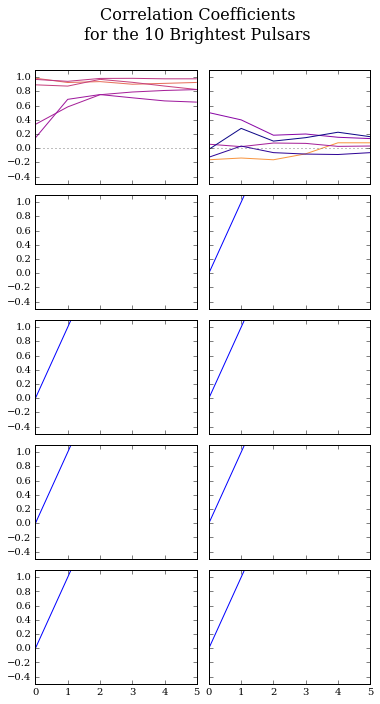

In [85]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap


#Define the overall plot, title and spacing
fig, ax = plt.subplots(figsize=(6,11), nrows=5, ncols=2, sharex=True, sharey=True)
fig.suptitle('Correlation Coefficients\nfor the 10 Brightest Pulsars', fontsize=16)
plt.subplots_adjust(wspace=0.075, hspace=0.1)

# Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 0.75, cmap.N // 2))
cmap = LinearSegmentedColormap.from_list('Lower Part', colors)

X=range(0,5)
C=range(0,5)

##== Defining the first subplot - J1713 ==##

days=(57305, 57302, 56380, 57319, 57041)
SNR=(23922.71, 18328.92, 17140.46, 13989.67, 13117.22)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1713+0747', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
ticks=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    ticks.append(data_dict.keys())
    
x=np.array(x)
y=np.array(y)


prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

print lines

#Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])

print lines
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)

lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[0,0].add_collection(lines)
ax[0,0].axhline(0, color='grey', linestyle=":")

ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(-0.5,1.1)
ax[0,0].yaxis.set_major_locator(MaxNLocator(prune='lower'))

##== Defining the second subplot - J1022 ==##

days=(57028, 57084, 57126, 57146, 57187, 57256) #, 57291, 57312, 57331, 57375)
SNR=(23922.71, 18328.92, 17140.46, 13989.67, 13117.22, 18328.92) #, 17140.46, 13989.67, 13117.22, 15000.1)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1022+1001', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
ticks=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    ticks.append(data_dict.keys())
    
x=np.array(x)
y=np.array(y)
z=np.array(z)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]
lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[0,1].add_collection(lines)
ax[0,1].axhline(0, color='grey', linestyle=":")

ax[0,1].yaxis.set_major_locator(MaxNLocator(prune='lower'))


ax[1,1].plot(X, C, linewidth=1.0, linestyle="-")
ax[2,0].plot(X, C, linewidth=1.0, linestyle="-")
ax[2,1].plot(X, C, linewidth=1.0, linestyle="-")
ax[3,0].plot(X, C, linewidth=1.0, linestyle="-")
ax[3,1].plot(X, C, linewidth=1.0, linestyle="-")
ax[4,0].plot(X, C, linewidth=1.0, linestyle="-")
ax[4,1].plot(X, C, linewidth=1.0, linestyle="-")

# plt.colorbar()


plt.show()

In [ ]:
#Fun with dictionaries
d=OrderedDict()
print d
d['dict1']=OrderedDict()
print d
d['dict1']['innerkey']='value'
print d

#To access the right dictionary values: http://stackoverflow.com/questions/21507956/plotting-dictionaries-within-a-dictionary-in-myplotlib-python

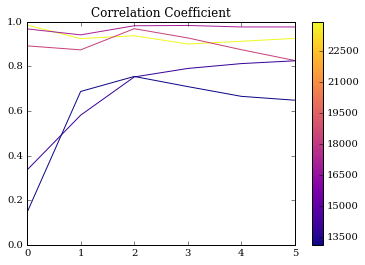

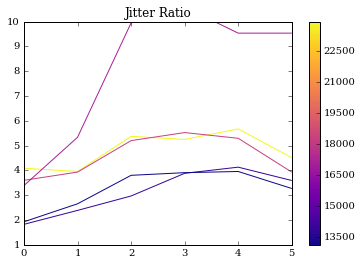

In [39]:
# days=(56201, 56577, 57305, 57302, 56458, 56380, 57319, 56934, 57041)
# SNR=(42051.24, 28191.58, 23922.71, 18328.92, 17335.41, 17140.46, 
#      13989.67, 13668.18, 13117.22)
days=(57305, 57302, 56380, 57319, 57041)
SNR=(23922.71, 18328.92, 17140.46, 13989.67, 13117.22)


plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1713+0747', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]


fig, ax = plt.subplots()
plt.title('Correlation Coefficient')
x=[]
y=[]
z=[]
ticks=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    ticks.append(data_dict.keys())
    
x=np.array(x)
y=np.array(y)
z=np.array(z)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]
lines = LineCollection(lines, array=z, cmap=plt.cm.plasma, linewidths=1)
ax.add_collection(lines)
ax.set_xlim(0,5)
# ax.set_xticklabels('320', '160', '80', '40', '20')
fig.colorbar(lines)

fig, ax = plt.subplots()
plt.title('Jitter Ratio')
i=[]
j=[]
k=[]
ticks=[]
for SNRval, data_dict in plotjitter.iteritems():
    i.append(range(len(data_dict)))
    j.append(data_dict.values())
    k.append(SNRval)
    ticks.append(data_dict.keys())
    
i=np.array(i)
j=np.array(j)
k=np.array(k)

prelines=np.array(zip(i,j))
lines = [zip(a,b) for a,b in prelines]
lines = LineCollection(lines, array=k, cmap=plt.cm.plasma, linewidths=1)
ax.add_collection(lines)
ax.set_ylim(1,10)
ax.set_xlim(0,5)
fig.colorbar(lines)



# plt.figure()
# plt.title('Correlation Coefficient')
# for SNRval, data_dict in plotcorr.iteritems():
#     x=range(len(data_dict))
#     y=data_dict.values()
#     plt.plot(x,y, label=str(SNRval))
#     plt.xticks(range(len(data_dict)), data_dict.keys())
#     plt.legend(bbox_to_anchor=(1, 1.04), loc=2, borderaxespad=0.75)
    
# plt.figure()
# plt.title('Jitter Ratio')
# for SNRval, data_dict in plotjitter.iteritems():
#     x=range(len(data_dict))
#     y=data_dict.values()
#     plt.plot(x,y, label=str(SNRval))
#     plt.xticks(range(len(data_dict)), data_dict.keys())
#     plt.ylim(0,10)
#     plt.legend(bbox_to_anchor=(1, 1.04), loc=2, borderaxespad=0.75)

In [ ]:
x=r.read_residuals(filename="/nimrod1/eschwab/residuals/J1713+0747_resid_56380_80F8.tmp")

In [ ]:
nums = np.array(range(0,10))
print nums
freqs = np.array([10, 300, 10 ,10 ,10, 300, 10, 10 ,10 ,300])

mask = (nums>3) & (nums<9) & (freqs>20)
print mask

print nums[mask]

In [ ]:
lis=open("tempo.lis", 'r').readlines()
print lis[252]

[[[ 0  1  2  3]
  [79 85 87 83]]

 [[ 0  1  2  3]
  [65 71 74 68]]

 [[ 0  1  2  3]
  [83 84 82 80]]]
[[(0, 79), (1, 85), (2, 87), (3, 83)], [(0, 65), (1, 71), (2, 74), (3, 68)], [(0, 83), (1, 84), (2, 82), (3, 80)]]


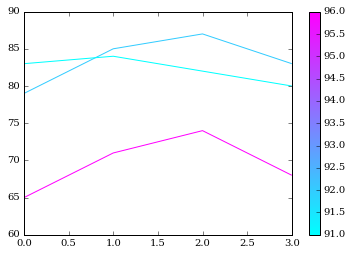

In [11]:
Temp1 = [79, 85, 87, 83]
Temp2 = [65, 71, 74, 68]
Temp3 = [83, 84, 82, 80]
Day = ['Mon', 'Tues', 'Weds', 'Thurs']
Humidity = [92, 96, 91]

weather1=OrderedDict()
for ii,jj in zip(Day, Temp1):
    weather1[ii]=jj
    
weather2=OrderedDict()
for ii,jj in zip(Day, Temp2):
    weather2[ii]=jj

weather3=OrderedDict()
for ii,jj in zip(Day, Temp3):
    weather3[ii]=jj
    
allweather=[weather1, weather2, weather3]

weather=OrderedDict()
for ii, jj in zip(Humidity, allweather):
    weather[ii]=jj

#weather is an ordered dictionary

fig, ax = plt.subplots()
x=[]
y=[]
z=[]
ticks=[]
for colorvar, data_dict in weather.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(colorvar)
    ticks.append(data_dict.keys())

x=np.array(x)
y=np.array(y)
z=np.array(z)

prelines=np.array(zip(x,y))
print prelines
lines = [zip(x,y) for x,y in prelines]
print lines
lines = LineCollection(lines, array=z, cmap=plt.cm.cool, linewidths=1)
ax.add_collection(lines)
ax.set_ylim(60, 90)
ax.set_xlim(0,3)
fig.colorbar(lines)

# lines=np.array(zip(x,y))
# newlines = [zip(x,y) for x,y in lines]

In [ ]:
import matplotlib.pyplot as plt
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=10000, vmax=20000))
Zs=z
sm.set_array(Zs)
plt.plot(x,y, c=Zs)
plt.colorbar(sm)